# 청년AI/BigData아카데미 22기
## ResNet

In [1]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


## Exercise 3-1. Implement Residual Block

In [2]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)])

train_data = torchvision.datasets.MNIST("./data", train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST("./data", train=False, download=True, transform=transform)

print(len(train_data))
print(len(test_data))

60000
10000


In [3]:
from torch.utils.data import DataLoader

batch_size = 8

trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

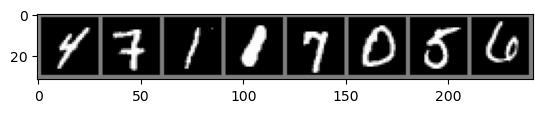

    4     7     1     1     7     0     5     6


In [4]:
# display some images

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.__next__()

# show images
imshow(torchvision.utils.make_grid(images))

classes = ('0', '1', '2', '3', '4', 
           '5', '6', '7', '8', '9')

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [5]:
import torch
import torch.nn as nn

In [6]:
class BasicBlock(nn.Module):
    ### implement this
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        ##forward ## conv, bn, relu, conv, bn , addition , relu
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1, stride = 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1, stride = 1, bias = False),
            nn.BatchNorm2d(out_channels)
        )
        
        self.shortcut = nn.Sequential()
        
        self.relu = nn.ReLU()
        
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size = 1, bias = False),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        ## input channel: 64, out channel: 128
        # residual_function -> 128 channel, shortcut 64
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

## Exercise 3-2. Implement ResNet-18

In [7]:
class ResNet18(nn.Module):
    def __init__(self, block, num_classes=10):
        super(ResNet18, self).__init__()
        ### implement this
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        )
        
        self.conv2_1 = block(64, 64)
        self.conv2_2 = block(64, 64)
        
        self.conv3_1 = block(64, 128)
        self.conv3_2 = block(128, 128)
        
        self.conv4_1 = block(128, 256)
        self.conv4_2 = block(256, 256)
        
        self.conv5_1 = block(256, 512)
        self.conv5_2 = block(512, 512)
        
        ## average pooling
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1)) # h*w ->1*1
        self.fc = nn.Linear(512, num_classes)
        
    def forward(self,x):
        # x:[batch, 3, 32, 32]
        ### implement this
        
        x = self.conv1(x)
        
        x = self.conv2_1(x)
        x = self.conv2_2(x)
        
        x = self.conv3_1(x)
        x = self.conv3_2(x)

        x = self.conv4_1(x)
        x = self.conv4_2(x)

        x = self.conv5_1(x)
        x = self.conv5_2(x) # [batch, 512, h, w]
        
        x = self.avg_pool(x) # [batch, 512, 1, 1]
        
        x = x.view(x.size(0), -1) # [batch, 512]
        
        x = self.fc(x) #[batch, 10]

        return x

In [8]:
!pip install torchsummary
from torchsummary import summary

net = ResNet18(BasicBlock)
summary(net, batch_size=-1, input_size=(1, 32, 32), device='cpu')
net = net.cuda()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           3,136
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

### Define a Loss function and optimizer
* Use Classification Cross-Entropy loss
* Use Adam with learning rate 0.0001 

In [9]:
import torch.optim as optim

# define a loss and optimizer
criterion = nn.CrossEntropyLoss() #CrossEntropyLoss에 softmax까지 구현되어있기 때문에 모델에 softmax를 선언하지 않아도 됨. 
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [10]:
def train(net, optimizer, epoch):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        images, labels = data
        images, labels = images.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 50 == 49:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0
            
def test(net):
    correct = 0.
    total = 0.
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    net.eval()
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        for idx in range(10): 
            label_idx = (labels == idx)
            if label_idx.sum().item() == 0: 
                continue
            class_correct[idx] += labels[label_idx].eq(torch.argmax(outputs[label_idx], 1)).sum().item()
            class_total[idx] += labels[label_idx].size(0)

    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [11]:
for epoch in range(0, 5):
    train(net, optimizer, epoch)
test(net)

[1,    50] loss: 1.295
[1,   100] loss: 0.706
[1,   150] loss: 0.420
[1,   200] loss: 0.442
[1,   250] loss: 0.319
[1,   300] loss: 0.442
[1,   350] loss: 0.318
[1,   400] loss: 0.341
[1,   450] loss: 0.285
[1,   500] loss: 0.270
[1,   550] loss: 0.228
[1,   600] loss: 0.264
[1,   650] loss: 0.177
[1,   700] loss: 0.213
[1,   750] loss: 0.206
[1,   800] loss: 0.176
[1,   850] loss: 0.248
[1,   900] loss: 0.201
[1,   950] loss: 0.254
[1,  1000] loss: 0.237
[1,  1050] loss: 0.223
[1,  1100] loss: 0.131
[1,  1150] loss: 0.156
[1,  1200] loss: 0.178
[1,  1250] loss: 0.191
[1,  1300] loss: 0.166
[1,  1350] loss: 0.116
[1,  1400] loss: 0.213
[1,  1450] loss: 0.118
[1,  1500] loss: 0.157
[1,  1550] loss: 0.121
[1,  1600] loss: 0.170
[1,  1650] loss: 0.154
[1,  1700] loss: 0.101
[1,  1750] loss: 0.140
[1,  1800] loss: 0.123
[1,  1850] loss: 0.115
[1,  1900] loss: 0.231
[1,  1950] loss: 0.147
[1,  2000] loss: 0.133
[1,  2050] loss: 0.130
[1,  2100] loss: 0.119
[1,  2150] loss: 0.163
[1,  2200] 

[3,  2900] loss: 0.028
[3,  2950] loss: 0.047
[3,  3000] loss: 0.038
[3,  3050] loss: 0.023
[3,  3100] loss: 0.023
[3,  3150] loss: 0.035
[3,  3200] loss: 0.014
[3,  3250] loss: 0.035
[3,  3300] loss: 0.034
[3,  3350] loss: 0.064
[3,  3400] loss: 0.070
[3,  3450] loss: 0.056
[3,  3500] loss: 0.114
[3,  3550] loss: 0.034
[3,  3600] loss: 0.060
[3,  3650] loss: 0.085
[3,  3700] loss: 0.073
[3,  3750] loss: 0.043
[3,  3800] loss: 0.020
[3,  3850] loss: 0.030
[3,  3900] loss: 0.055
[3,  3950] loss: 0.026
[3,  4000] loss: 0.013
[3,  4050] loss: 0.024
[3,  4100] loss: 0.033
[3,  4150] loss: 0.031
[3,  4200] loss: 0.039
[3,  4250] loss: 0.074
[3,  4300] loss: 0.074
[3,  4350] loss: 0.098
[3,  4400] loss: 0.023
[3,  4450] loss: 0.018
[3,  4500] loss: 0.023
[3,  4550] loss: 0.068
[3,  4600] loss: 0.049
[3,  4650] loss: 0.053
[3,  4700] loss: 0.055
[3,  4750] loss: 0.043
[3,  4800] loss: 0.023
[3,  4850] loss: 0.014
[3,  4900] loss: 0.046
[3,  4950] loss: 0.098
[3,  5000] loss: 0.023
[3,  5050] 

[5,  5750] loss: 0.046
[5,  5800] loss: 0.019
[5,  5850] loss: 0.011
[5,  5900] loss: 0.008
[5,  5950] loss: 0.023
[5,  6000] loss: 0.027
[5,  6050] loss: 0.037
[5,  6100] loss: 0.033
[5,  6150] loss: 0.026
[5,  6200] loss: 0.019
[5,  6250] loss: 0.013
[5,  6300] loss: 0.032
[5,  6350] loss: 0.053
[5,  6400] loss: 0.015
[5,  6450] loss: 0.036
[5,  6500] loss: 0.021
[5,  6550] loss: 0.012
[5,  6600] loss: 0.013
[5,  6650] loss: 0.042
[5,  6700] loss: 0.025
[5,  6750] loss: 0.031
[5,  6800] loss: 0.025
[5,  6850] loss: 0.018
[5,  6900] loss: 0.033
[5,  6950] loss: 0.016
[5,  7000] loss: 0.025
[5,  7050] loss: 0.028
[5,  7100] loss: 0.015
[5,  7150] loss: 0.019
[5,  7200] loss: 0.017
[5,  7250] loss: 0.012
[5,  7300] loss: 0.017
[5,  7350] loss: 0.013
[5,  7400] loss: 0.024
[5,  7450] loss: 0.020
[5,  7500] loss: 0.031
Accuracy of the network on the test images: 98 %
Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 94 %
Accuracy of     3 : 98 %
Accuracy of     4 : 99 

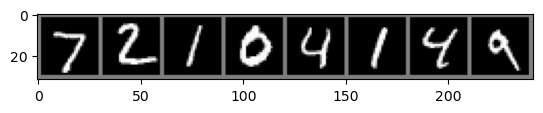

GrondTruth:      7     2     1     0     4     1     4     9


In [13]:
dataiter = iter(testloader)
images, labels = dataiter.__next__()
#print images
imshow(torchvision.utils.make_grid(images))
print('GrondTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


In [14]:
images = images.cuda()
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted(net_plain): ', ' '.join('%5s' % classes[predicted[j]] for j in range(batch_size))) 


Predicted(net_plain):      7     2     1     0     4     1     4     9


In [15]:
test(net)

Accuracy of the network on the test images: 98 %
Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 94 %
Accuracy of     3 : 98 %
Accuracy of     4 : 99 %
Accuracy of     5 : 99 %
Accuracy of     6 : 98 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 97 %
